**Summary:**
- Made some visualizations to find out how the data looks like.
- Data has seasonality and trend, so Holt-Winters' method (also called triple exponential smoothing) can be used.
- Damped, additive HW method fails to account for trend but models the seasonality very well.
- I was unable to try out multiplicative HW method because it cannot be used for negative data, despite the book (Forecasting: Principles and Practice) saying that multiplicative models usually give excellent results. To circumvent this, I could try offsetting all the data by some amount to make all data points positive, apply the forecasting and then de-offset to the original position. 
- Period of time series data is 24 hours, found by trial and error while decomposing data into trend, seasonality and residuals. I found it difficult to understand at first and it took me so long, but in hindsight it makes sense because this is (weekly/)daily(/hourly) data, so the seasonality can either be (daily/)hourly(minutely) (around 3 observations are taken every hour). 
- The best decomposition results came from specifying `period=24`.
- Surprisingly found Python to be a bit lacking in the forecasting department. R has excellent packages, quick visualizations and forecast functions. 

**To do:**
- Implement damped, multiplicative HW method in R using a constant offset on the data.
- Forecast for all 300 Test satellites and 6 kinematic states separately. Very naive approach but gotta start somewhere.
- Next method to study and use will be the machine learning approach SVM.

**Ismail Dawoodjee 1:55am 26-Jan-2020**

### 22-Jan-2020

## Data Visualization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
#sns.set(rc={'figure.figsize':(16, 4)})
#plt.rc('figure',figsize=(16,12))
#plt.rc('font',size=13)

In [139]:
#!pip install seaborn

In [140]:
#!python -m pip install --upgrade pip

In [2]:
train1 = pd.read_pickle('train1.pkl')

In [3]:
test1 = pd.read_pickle('test1.pkl')

In [14]:
train1.head()

,id,epoch,abs_time,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
958,1819,2014-01-01 00:00:00.000,00:00:00,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227
959,1820,2014-01-01 00:21:11.845,00:21:11.845000,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049
960,1821,2014-01-01 00:42:23.690,00:42:23.690000,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255
961,1822,2014-01-01 01:03:35.534,01:03:35.534000,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723
962,1823,2014-01-01 01:24:47.379,01:24:47.379000,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010


In [15]:
train1.tail()

,id,epoch,abs_time,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
3061,3922,2014-01-31 22:15:45.938,30 days 22:15:45.938000,1,-33092.618399,-281.511542,-1582.378975,0.094088,-1.839427,1.337545,-29406.078919,-2719.769909,-1476.299104,0.903445,-2.329687,1.355335
3062,3923,2014-01-31 22:36:57.783,30 days 22:36:57.783000,1,-32678.193673,-2611.293944,127.879530,0.559090,-1.818598,1.347891,-27882.742274,-5634.903507,259.572177,1.498239,-2.242285,1.367602
3063,3924,2014-01-31 22:58:09.628,30 days 22:58:09.628000,1,-31665.342406,-4892.533056,1835.695504,1.036204,-1.762460,1.333303,-25577.429154,-8389.868466,1986.924648,2.134397,-2.074305,1.340251
3064,3925,2014-01-31 23:19:21.473,30 days 23:19:21.473000,1,-30034.378237,-7077.220106,3507.336506,1.532305,-1.665557,1.290191,-22432.558095,-10865.836350,3646.968029,2.819524,-1.797623,1.258773
3065,3926,2014-01-31 23:40:33.318,30 days 23:40:33.318000,1,-27756.260690,-9107.885238,5102.708242,2.055278,-1.518181,1.211938,-18382.812351,-12896.945935,5156.151522,3.557107,-1.364583,1.097643


In [6]:
test1.head()

,id,sat_id,epoch,abs_time,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01 00:01:45.162,31 days 00:01:45.162000,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01 00:22:57.007,31 days 00:22:57.007000,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01 00:44:08.852,31 days 00:44:08.852000,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01 01:05:20.697,31 days 01:05:20.697000,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01 01:26:32.542,31 days 01:26:32.542000,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [7]:
test1.tail()

,id,sat_id,epoch,abs_time,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
1896,5823,1,2014-02-28 21:30:51.070,58 days 21:30:51.070000,-12172.502254,-14729.896827,7614.241477,4.406935,-0.495499,0.456099
1897,5824,1,2014-02-28 21:52:02.915,58 days 21:52:02.915000,-6136.919502,-14726.318844,7862.718555,5.058846,0.579143,-0.109441
1898,5825,1,2014-02-28 22:13:14.759,58 days 22:13:14.759000,553.235044,-13011.265336,7194.565001,5.357535,2.231405,-1.008146
1899,5826,1,2014-02-28 22:34:26.604,58 days 22:34:26.604000,7007.220162,-8771.583052,5124.655752,4.490665,4.502656,-2.296487
1900,5827,1,2014-02-28 22:55:38.449,58 days 22:55:38.449000,10996.426875,-1764.703560,1427.176527,1.424435,6.222616,-3.371827


In [8]:
train1.shape

(2108, 16)

In [9]:
test1.shape

(1901, 10)

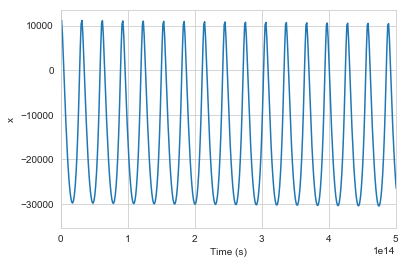

In [224]:
plt.plot(train1['abs_time'], train1['x'])
plt.xlabel('Time (s)')
plt.ylabel('x')
plt.xlim(0,0.5e15);

Text(0, 0.5, 'x-position')

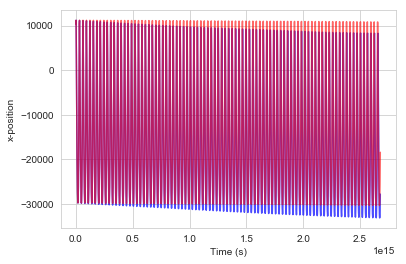

In [100]:
plt.plot(train1['abs_time'], train1['x'], color='blue', alpha=0.7)
plt.plot(train1['abs_time'], train1['x_sim'], color='red', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('x-position')

In [28]:
# create a function to plot the true and simulated kinematic states
def plot_kinematics(df, sim=True):
    """
    Takes in a dataframe and plots (x,y,z,Vx,Vy,Vz) and sim(x,y,z,Vx,Vy,Vz) against abs_time, both in the same figure
    If sim is False, simulated kinematics are not plotted <- put this feature later
    """
    
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, sharex=True, figsize=(15,10))
    fig.suptitle('True and Simulated Kinematics')
    t = df['abs_time']/1e9
    
    ax1.set_title('True (Blue) Simulated (Red)')
    ax1.plot(t, df['x'], 'b')  
    ax1.plot(t, df['x_sim'], 'r', alpha=1)
    ax1.set(xlabel='Time (s)', ylabel='x')
    
    ax3.plot(t, df['y'], 'b', t, df['y_sim'], 'r', alpha=1)
    ax3.set(xlabel='Time (s)', ylabel='y')
    
    ax5.plot(t, df['z'], 'b', t, df['z_sim'], 'r', alpha=1)
    ax5.set(xlabel='Time (s)', ylabel='z')
    
    ax2.set_title('True (Green) Simulated (Red)')
    ax2.plot(t, df['Vx'], 'g', t, df['Vx_sim'], 'r', alpha=1)
    ax2.set(xlabel='Time (s)', ylabel='Vx')
    
    ax4.plot(t, df['Vy'], 'g', t, df['Vy_sim'], 'r', alpha=1)
    ax4.set(xlabel='Time (s)', ylabel='Vy')
    
    ax6.plot(t, df['Vz'], 'g', t, df['Vz_sim'], 'r', alpha=1)
    ax6.set(xlabel='Time (s)', ylabel='Vz')


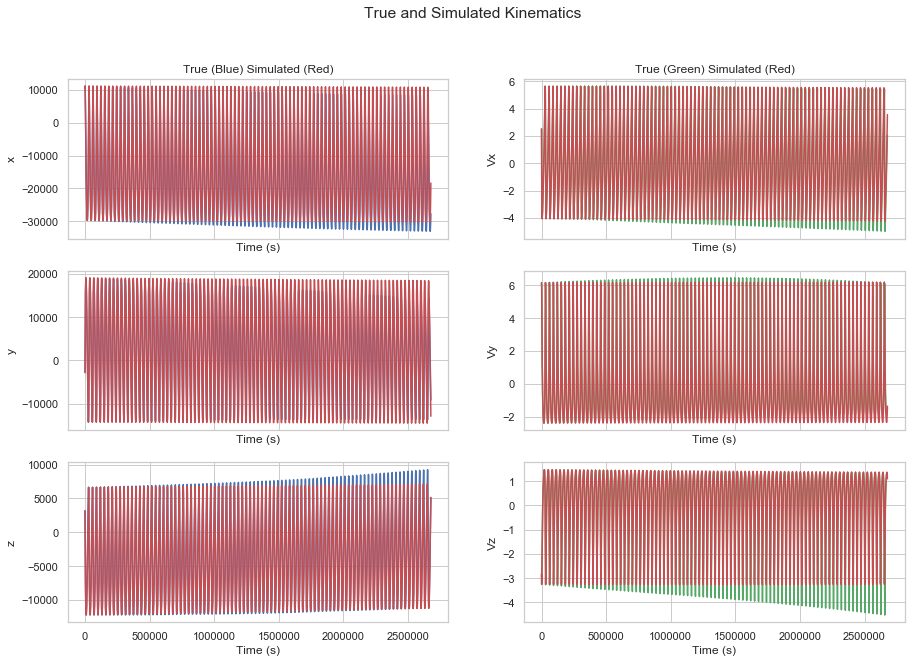

In [29]:
plot_kinematics(train1)

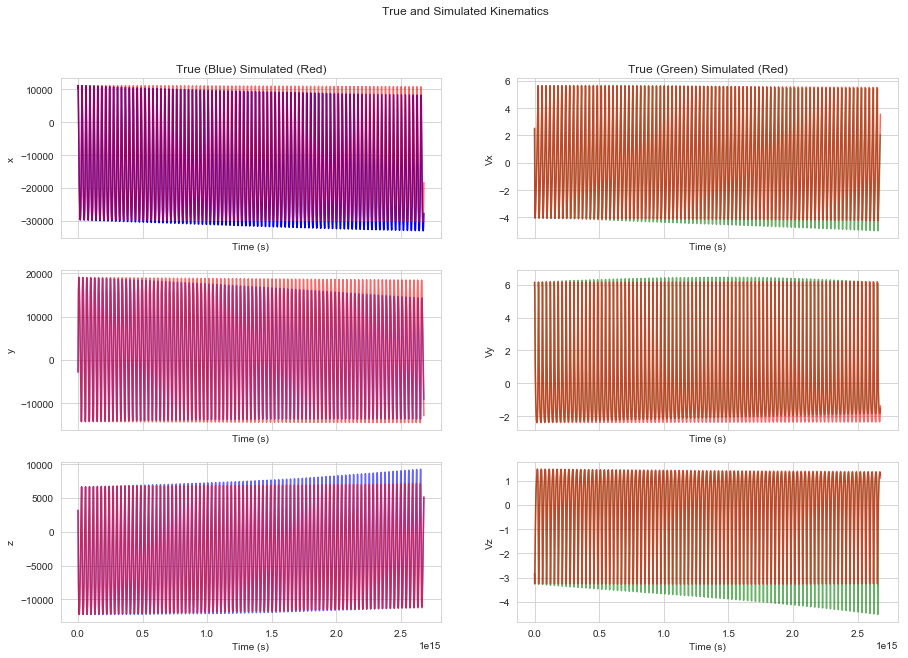

In [234]:
plot_kinematics(train1)

Several findings can be deduced from the above plots:
- RSO kinematics display a "seasonal" pattern, which makes sense because a full orbit occurs over a fixed period of time (unless external forces come into play).
- There are no cyclical patterns displayed by the data.
- Some kinematic components display a clear trend (e.g. x-position) while other trends cannot be seen as easily.
- Simulated trajectories are initially accurate in predicting true trajectories but becomes inaccurate in future epochs.

To distinguish between cyclical and seasonal patterns, an extract from a book says: "If the fluctuations are not of a fixed frequency then they are cyclic; if the frequency is unchanging and associated with some aspect of the calendar, then the pattern is seasonal." (Forecasting: Principles and Practice) Since the fluctuations occur over a fixed orbital period, the pattern should be "seasonal".

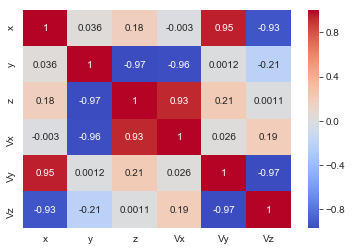

In [4]:
# correlation plot
sns.heatmap(train1[['x','y','z','Vx','Vy','Vz']].corr(), cmap='coolwarm', annot=True)

### 23-Jan-2020

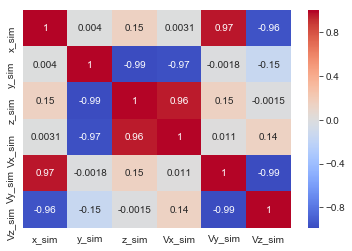

In [6]:
# not sure how these correlations will help
sns.heatmap(test1[['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']].corr(), cmap='coolwarm', annot=True)

In [246]:
# cell to quickly reset train1
train1 = pd.read_pickle('train1.pkl')

The cell below is just for information. **DO NOT RUN THIS CELL**

In [48]:
# create error columns (X_sim - X) / X for each of the six kinematic components
# for column numbers from 4 to 9, name the new column 'e' + 'kth_column_name' to signify error in the simulated kinematics,
# which should be calculated by subtracting the true kinematic state from the simulated kinematic state

#for k in range(4,10):
    
    # absolute errors
    #train1[f"e{train1.columns[k]}"] = train1.iloc[:,k+6] - train1.iloc[:,k]
    
    # fractional and percentage errors
    #train1[f"e{train1.columns[k]}"] = (train1.iloc[:,k+6] / train1.iloc[:,k]) - 1  #*100

In [247]:
train1.shape

(2108, 16)

In [142]:
# define function to create error columns and plot them against time
def plot_errors(df=train1, frac=True):
    """Takes in the train1 dataframe, creates error columns using the difference between true and simulated states
    and plots these errors depending on whether they are specified to be fractional or absolute."""
    
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(15,10))
    t = df['abs_time']
    true_state = range(4,10)
    
    if frac:
        for k in true_state:
            df[f"e{df.columns[k]}"] = (df.iloc[:,k+6] / df.iloc[:,k]) - 1
            fig.suptitle('Fractional error in simulated states')
    else:
        for k in true_state:
            df[f"e{df.columns[k]}"] = df.iloc[:,k+6] - df.iloc[:,k]
            fig.suptitle('Absolute error in simulated states')
    
    for k in true_state:
        j = int(k + 12 - 0.5*(k-4) + 2.5*((k-4)%2)) # took me 2 hours to come up with this
        axs.flat[k-4].plot(t, df.iloc[:,j]) 
        #axs.flat[k-4].set_title(df.columns[int(k + 12 - 0.5*(k-4) + 2.5*((k-4)%2))])
        axs.flat[k-4].set(xlabel='Time (s)', ylabel=df.columns[j]) 

In [249]:
train1.head()

,id,epoch,abs_time,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
958,1819,2014-01-01 00:00:00.000,00:00:00,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227
959,1820,2014-01-01 00:21:11.845,00:21:11.845000,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049
960,1821,2014-01-01 00:42:23.690,00:42:23.690000,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255
961,1822,2014-01-01 01:03:35.534,01:03:35.534000,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723
962,1823,2014-01-01 01:24:47.379,01:24:47.379000,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010


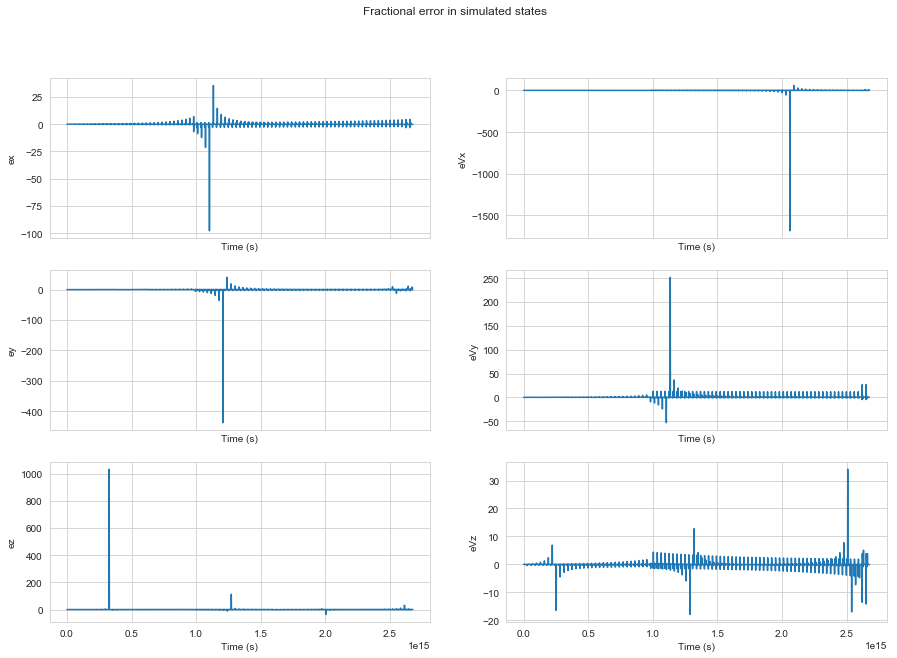

In [255]:
plot_errors()

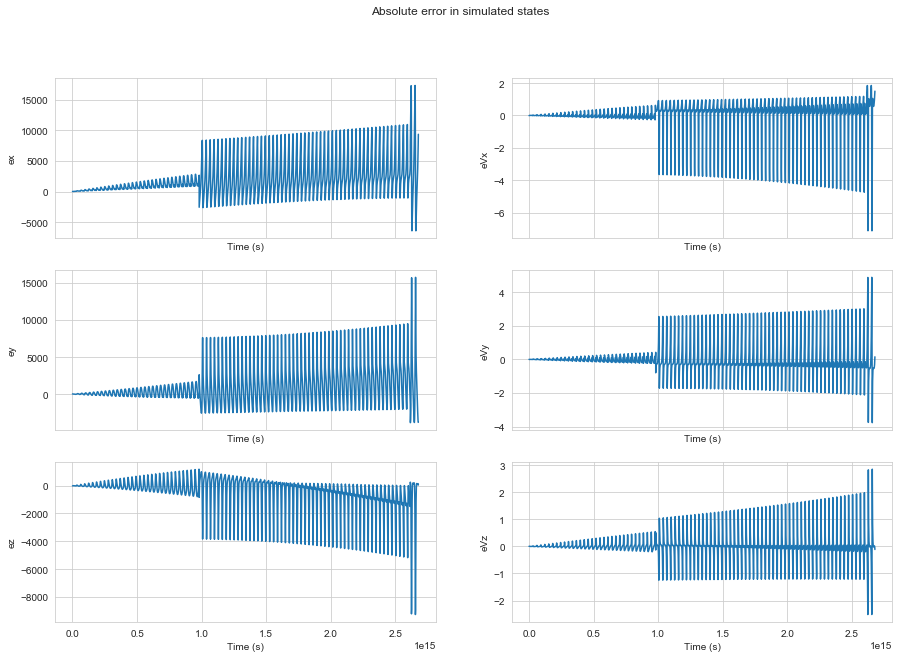

In [143]:
plot_errors(frac=False)

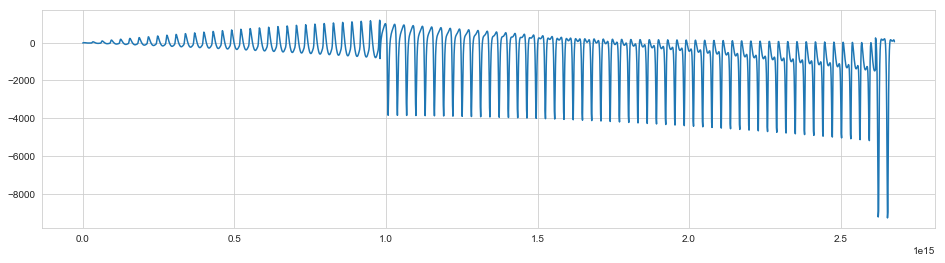

In [145]:
plt.figure(figsize=(16,4))
plt.plot(train1['abs_time'],train1['ez'])

Started learning time series analysis from this course:

https://courses.analyticsvidhya.com/courses/take/creating-time-series-forecast-using-python

and from this book:

https://otexts.com/fpp2/

### 24-Jan-2020

In [292]:
train1 = pd.read_pickle('train1.pkl')
test1 = pd.read_pickle('test1.pkl')

In [293]:
train1_original = train1.copy()
test1_original = test1.copy()

In [294]:
train1.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
958,1819,2014-01-01 00:00:00.000,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227
959,1820,2014-01-01 00:21:11.845,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049
960,1821,2014-01-01 00:42:23.690,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255
961,1822,2014-01-01 01:03:35.534,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723
962,1823,2014-01-01 01:24:47.379,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010


In [11]:
# reset indices to epochs
train1.index = train1['epoch']
test1.index = test1['epoch']

In [296]:
test1.head()

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
epoch,,,,,,,,,
2014-02-01 00:01:45.162,3927,1,2014-02-01 00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
2014-02-01 00:22:57.007,3928,1,2014-02-01 00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2014-02-01 00:44:08.852,3929,1,2014-02-01 00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
2014-02-01 01:05:20.697,3930,1,2014-02-01 01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
2014-02-01 01:26:32.542,3931,1,2014-02-01 01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


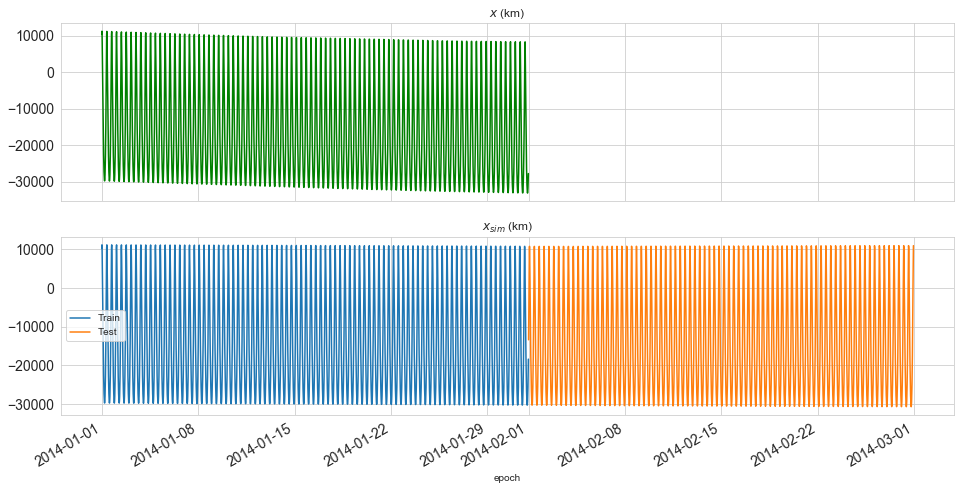

In [65]:
# plot time series for x
fig, axs = plt.subplots(2,1, sharex=True)
train1['x'].plot(figsize=(16,8), title='$x$ (km)', fontsize=14, ax=axs[0], label='Train', color='green')
train1['x_sim'].plot(figsize=(16,8), title='$x_{sim}$ (km)', fontsize=14, ax=axs[1], label='Train')
test1['x_sim'].plot(figsize=(16,8), title='$x_{sim}$ (km)', fontsize=14, ax=axs[1], label='Test')
plt.legend(loc='best')
plt.show()

Two approaches can be taken here:

1. Ignore $x_{sim}$ and use traditional forecasting methods to forecast directly for $x$.
2. Calculate errors $e_x = x_{sim} - x$ for use in forecasting/ML and then subtract the errors from $x_{sim}$ to get $x$.

In [12]:
train1_x = train1['x']

In [103]:
lis1 = list(train1['abs_time'])

In [104]:
lis1.sort()

In [111]:
lis1[1] - lis1[0]

Timedelta('0 days 00:21:11.845000')

In [4]:
import statsmodels.api as sm

In [14]:
# quick decomposition of time series into trend, seasonality and residuals
# period can only take integer values
# tsa is time series analysis
decomp = sm.tsa.seasonal_decompose(train1_x, period=1, model='additive')

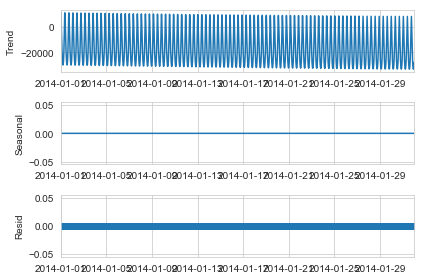

In [15]:
# seasonal and trend should be opposite?
fig = decomp.plot(observed=False)

### 25-Jan-2020

In [61]:
# convert to csv for analysis in R
train1.to_csv('train1.csv')
test1.to_csv('test1.csv')

In [24]:
train1 = train1.set_index('epoch')
test1 = test1.set_index('epoch')

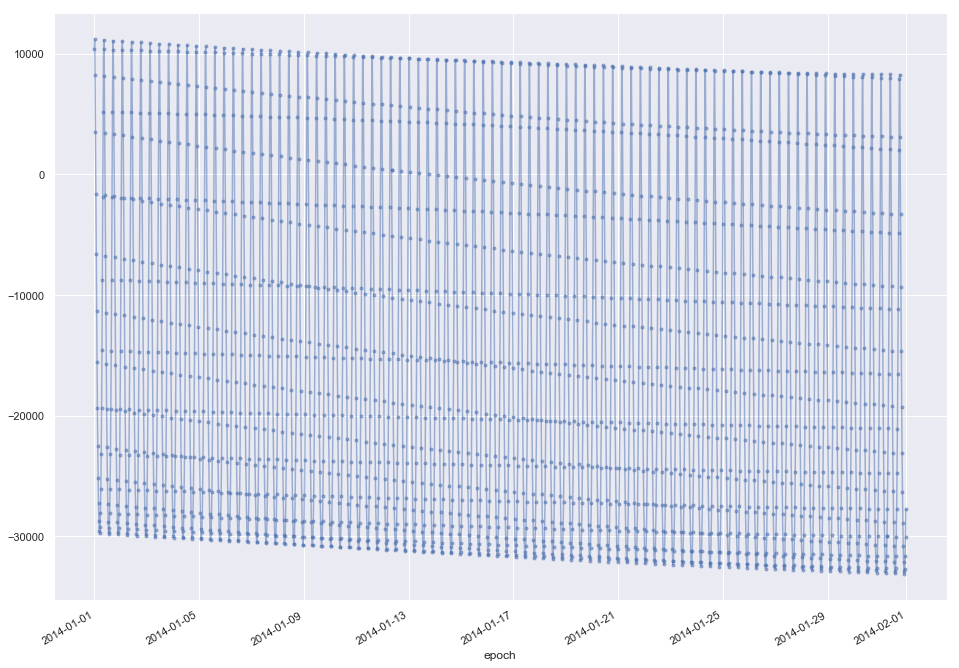

In [297]:
#train1['x'].plot(linewidth=0.5)
train1['x'].plot(marker='.', alpha=0.5)

In [25]:
# data has a trend, is seasonal and contains negative values
# need to detrend, deseasonalize data before fitting a model
from statsmodels.tsa.seasonal import seasonal_decompose

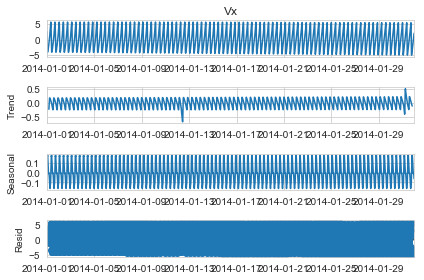

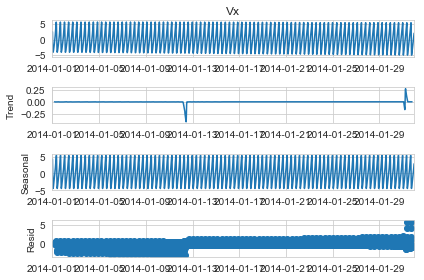

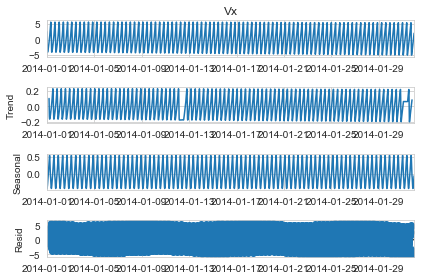

In [27]:
for p in range(23,26):
    result = seasonal_decompose(train1['Vx'], model='additive', period=p)
    result.plot()
    plt.show()

24 hours is the time series period.

In [302]:
train1.to_csv('train1.csv')
test1.to_csv('test1.csv')

In [28]:
# use additive decomposition and seasonal holt-winters method 

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
y_hat_avg = test1.copy()
x_hat_avg = train1.copy()

In [30]:
def forecast_plot(k='x', plot_sim=True, damp=False):
    
    fit1 = ExponentialSmoothing(np.asarray(train1[k]), trend='add', seasonal='add', seasonal_periods=24, damped=damp).fit()
    y_hat_avg['Holt_Winter'] = fit1.forecast(len(test1))
    #y_hat_avg['pred'] = fit1.predict(start=len(test1), end=2*len(test1)-1)

    plt.figure(figsize=(16,4))
    plt.title(f'Forecast of {k}')
    plt.plot(train1[k], label='Train')
    plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter', marker='.')
    #plt.plot(y_hat_avg['pred'], label='using pred', alpha=0.5, marker='.')
    #plt.plot(wut['what?'], label='using predict')
    
    if plot_sim:
        plt.plot(test1[f'{k}_sim'], label='Test_sim', alpha=0.5)
    else:
        pass
    
    plt.legend(loc='best')
    plt.show()

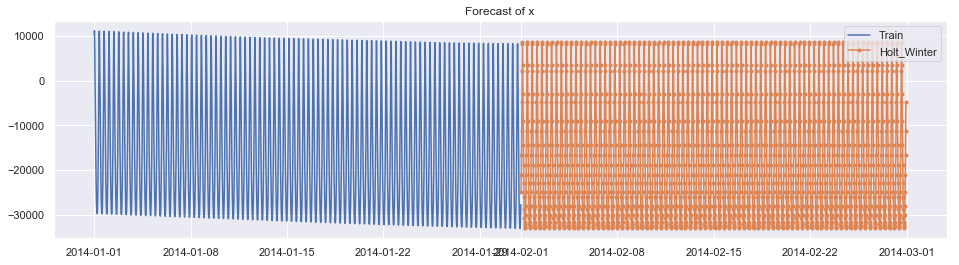

In [22]:
forecast_plot(k='x', plot_sim=False, damp=True)

In [441]:
fit1.params

{'smoothing_level': 0.052635507091361236,
 'smoothing_slope': 0.052635507091361236,
 'smoothing_seasonal': 0.9473686392828533,
 'damping_slope': 0.00010000000000098918,
 'initial_level': 0.009999999999999988,
 'initial_slope': 0.01,
 'initial_seasons': array([ 4110.5539597 , 11985.66619839, 18352.91649343, 22541.20737689,
        24930.33056557, 25970.99198458, 25999.93372936, 25254.5431246 ,
        23905.04972   , 22078.09247383, 19872.07602964, 17367.23604503,
        14632.5865966 , 11731.15875526,  8724.4912232 ,  5677.15881656,
         2662.18167237,  -231.49566005, -2887.45250713, -5142.42719487,
        -6751.92462557, -7327.9127489 , -6238.27908761, -2568.8157864 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [367]:
len(y_hat_avg)

1901

In [368]:
len(w)

1902

In [194]:
y_hat_avg.head()

,id,sat_id,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,Holt_Winter
epoch,,,,,,,,,
2014-02-01 00:01:45.162,3927,1,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,-11294.928094
2014-02-01 00:22:57.007,3928,1,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,-12776.619620
2014-02-01 00:44:08.852,3929,1,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,-13778.019987
2014-02-01 01:05:20.697,3930,1,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,-14054.336465
2014-02-01 01:26:32.542,3931,1,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,-13178.345338


### Group of important libraries 

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.seasonal import seasonal_decompose

In [40]:
max1 = np.sort(list(train1['x']))[-1]
max2 = np.sort(list(train1['x']))[-2]

In [44]:
train1[train1['x'] == max1].index

DatetimeIndex(['2014-01-01 00:21:11.845000'], dtype='datetime64[ns]', name='epoch', freq=None)

In [45]:
train1[train1['x'] == max2].index

DatetimeIndex(['2014-01-01 08:49:56.120000'], dtype='datetime64[ns]', name='epoch', freq=None)

In [56]:
train1[train1['x'] == np.sort(list(train1['x']))[0]].index - train1[train1['x'] == np.sort(list(train1['x']))[1]].index

TimedeltaIndex(['08:28:44.275000'], dtype='timedelta64[ns]', name='epoch', freq=None)

In [58]:
freq1 = '08:28:44.275000'
'08:28:44.276000'
'08:28:44.275000'
'08:28:44.275000'
'08:28:44.276000'
'08:28:44.275000'

'08:28:44.275000'

Calculate and plot radius of trajectory, tangential velocity and angular momentum per unit mass ($rV$)

In [212]:
train1['r'] = np.sqrt(train1['x']**2 + train1['y']**2 + train1['z']**2)

In [215]:
train1['V'] = np.sqrt(train1['Vx']**2 + train1['Vy']**2 + train1['Vz']**2)

In [218]:
train1['rV'] = train1['r'] * train1['V']

In [219]:
train1.head()

,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,r,V,rV
epoch,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00.000,1819,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227,11220.000000,7.222864,81040.533540
2014-01-01 00:21:11.845,1820,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049,12322.272031,6.768838,83407.457072
2014-01-01 00:42:23.690,1821,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255,14857.332389,5.897102,87615.206210
2014-01-01 01:03:35.534,1822,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723,17767.643418,5.097712,90574.333730
2014-01-01 01:24:47.379,1823,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010,20554.891076,4.461303,91701.588830


In [222]:
train1.tail()

,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,r,V,rV
epoch,,,,,,,,,,,,,,,,,
2014-01-31 22:15:45.938,3922,1,-33092.618399,-281.511542,-1582.378975,0.094088,-1.839427,1.337545,-29406.078919,-2719.769909,-1476.299104,0.903445,-2.329687,1.355335,33131.624839,2.276262,75416.269711
2014-01-31 22:36:57.783,3923,1,-32678.193673,-2611.293944,127.879530,0.559090,-1.818598,1.347891,-27882.742274,-5634.903507,259.572177,1.498239,-2.242285,1.367602,32782.610496,2.331671,76438.265766
2014-01-31 22:58:09.628,3924,1,-31665.342406,-4892.533056,1835.695504,1.036204,-1.762460,1.333303,-25577.429154,-8389.868466,1986.924648,2.134397,-2.074305,1.340251,32093.621911,2.440835,78335.245728
2014-01-31 23:19:21.473,3925,1,-30034.378237,-7077.220106,3507.336506,1.532305,-1.665557,1.290191,-22432.558095,-10865.836350,3646.968029,2.819524,-1.797623,1.258773,31055.632821,2.605116,80903.530499
2014-01-31 23:40:33.318,3926,1,-27756.260690,-9107.885238,5102.708242,2.055278,-1.518181,1.211938,-18382.812351,-12896.945935,5156.151522,3.557107,-1.364583,1.097643,29654.699668,2.828044,83864.810182


In [221]:
y_hat_avg.head()

,id,sat_id,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,Holt_Winter
epoch,,,,,,,,,
2014-02-01 00:01:45.162,3927,1,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774,-11294.928094
2014-02-01 00:22:57.007,3928,1,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402,-12776.619620
2014-02-01 00:44:08.852,3929,1,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412,-13778.019987
2014-02-01 01:05:20.697,3930,1,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600,-14054.336465
2014-02-01 01:26:32.542,3931,1,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724,-13178.345338


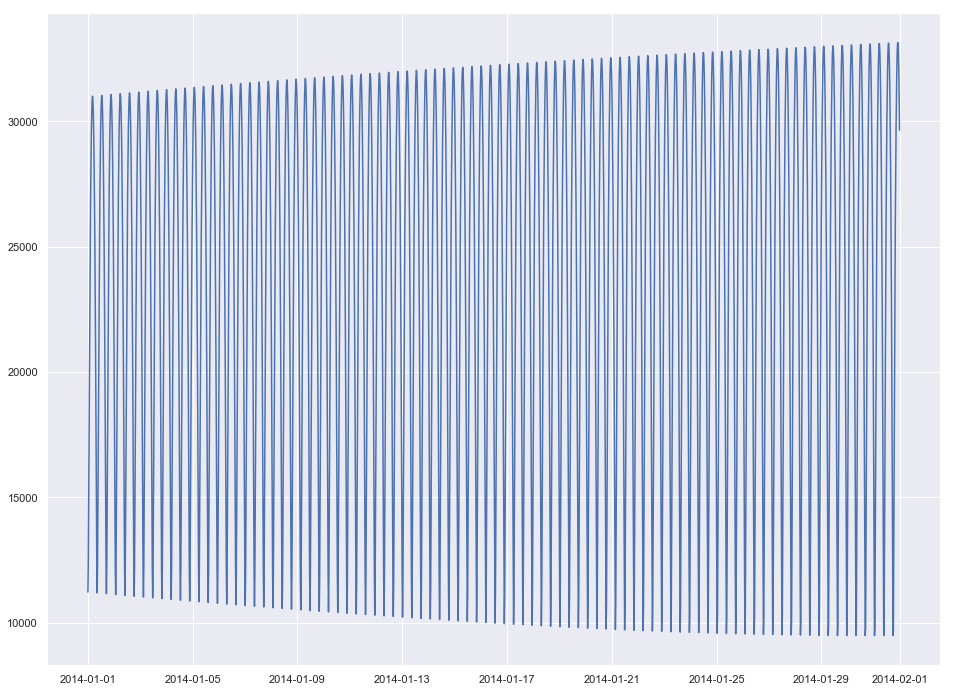

In [214]:
plt.plot(train1['r'])

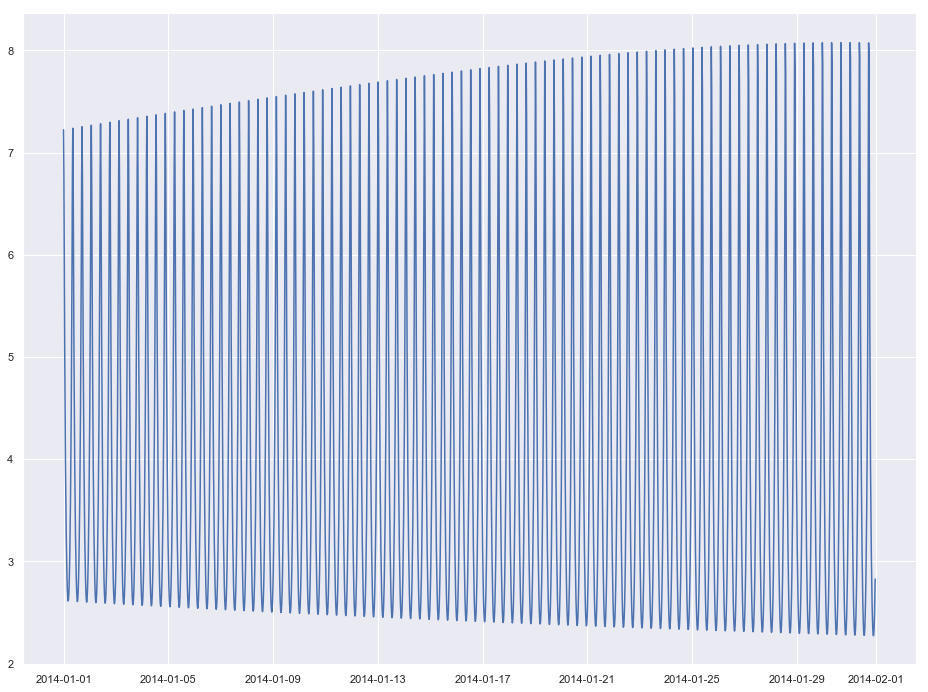

In [217]:
plt.plot(train1['V'])

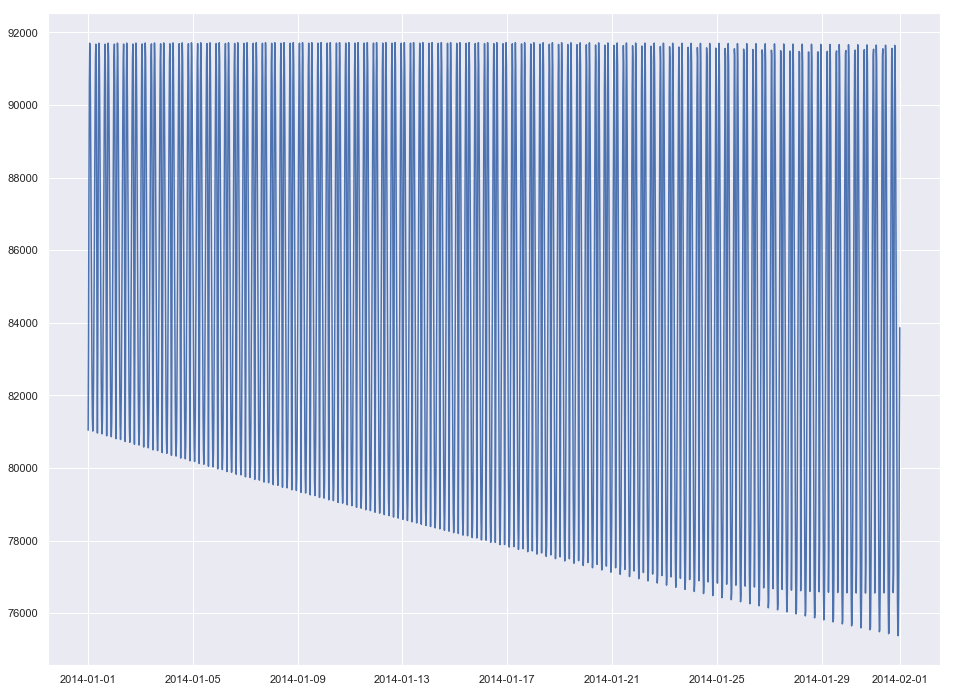

In [220]:
plt.plot(train1['rV'])

Angular momentum per unit mass is not constant, which confirms that there are non-conservative forces at work (solar pressure, atmospheric drag).